In [1]:
import torch
import dill
import matplotlib.pyplot as plt
from diffusion_policy.policy.diffusion_unet_timm_policy import DiffusionUnetTimmPolicy
from diffusion_policy.model.vision.timm_obs_encoder import TimmObsEncoder
from torch.utils.data import DataLoader
import hydra
from PIL import Image
import numpy as np
from captum.attr import visualization
import math
import cv2
from ipywidgets import interact, IntSlider
from diffusion_policy.dataset.umi_dataset import UmiDataset


2024-11-20 03:00:45.821939: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 03:00:45.872128: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-20 03:00:46.620255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/michael-lutz/miniconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/michael-lutz/miniconda3/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106det

In [2]:
ckpt_path = "/home/michael-lutz/umi_checkpoints/cup_policy/cup_wild_vit_l_1img.ckpt"
payload = torch.load(open(ckpt_path, 'rb'), map_location='cpu', pickle_module=dill)

In [3]:
policy = hydra.utils.instantiate(payload['cfg'].policy)
policy.load_state_dict(payload['state_dicts']['model'])
horizon = payload['cfg'].task.shape_meta.obs.camera0_rgb.horizon

vit will use the CLS token. feature_aggregation (attention_pool_2d) is ignored!


rgb keys:          ['camera0_rgb']
low_dim_keys keys: ['robot0_eef_pos', 'robot0_eef_rot_axis_angle', 'robot0_eef_rot_axis_angle_wrt_start', 'robot0_gripper_width']


In [4]:
obs_encoder = policy.obs_encoder
vit = obs_encoder.key_model_map['camera0_rgb']

In [5]:
shape_meta = payload['cfg'].task.shape_meta
data_path = "/data/cup_in_the_wild.zarr.zip"
dataset = UmiDataset(shape_meta=shape_meta, dataset_path=data_path)


In [6]:
dataloader = DataLoader(dataset, shuffle=False, batch_size=1)

In [7]:
def process_img(img: torch.Tensor):
    """Processes an image tensor to be used as input to the model.
    
    img: (B, C, H, Ws) tensor
    """
    img = obs_encoder.key_transform_map['camera0_rgb'](img)
    return img

In [8]:
dataset[0]['obs'].keys()

dict_keys(['camera0_rgb', 'robot0_eef_pos', 'robot0_eef_rot_axis_angle', 'robot0_gripper_width', 'robot0_eef_rot_axis_angle_wrt_start'])

In [9]:
obs_encoder.key_shape_map

{'camera0_rgb': (3, 224, 224),
 'robot0_eef_pos': (3,),
 'robot0_eef_rot_axis_angle': (6,),
 'robot0_gripper_width': (1,),
 'robot0_eef_rot_axis_angle_wrt_start': (6,)}

In [10]:
dataset[0]['obs']['camera0_rgb'].shape

torch.Size([1, 3, 224, 224])

In [11]:
episode = next(iter(dataloader))

In [12]:
policy.forward(episode)

tensor(0.0280, grad_fn=<MeanBackward0>)

In [13]:
# Hook function factory
from typing import Callable, List

def forward_hook_factory_qkv(attention_values: List[torch.Tensor]) -> Callable[[torch.nn.Module, torch.Tensor, torch.Tensor], None]:
    def forward_hook(module, input_tensor, output_tensor):
        attention_values.append(output_tensor)
    return forward_hook

def forward_hook_factory_proj(proj_values: List[torch.Tensor]) -> Callable[[torch.nn.Module, torch.Tensor, torch.Tensor], None]:
    def forward_hook(module, input_tensor, output_tensor):
        proj_values.append(input_tensor)
    return forward_hook


def backward_hook_factory(attention_grads: List[torch.Tensor]) -> Callable[[torch.nn.Module, torch.Tensor, torch.Tensor], None]:
    def backward_hook(module, grad_input_tensor, grad_output_tensor):
        attention_grads.append(grad_output_tensor[0])
    return backward_hook

In [14]:
# Attention utils
def get_attention_map(qkv, d_model=1024, num_heads=16):
    assert qkv.shape[-1] == d_model * 3
    head_dim = d_model // num_heads

    q = qkv[:, :, :d_model]
    k = qkv[:, :, d_model:2*d_model]

    q = q.view(q.shape[0], q.shape[1], num_heads, head_dim)
    k = k.view(k.shape[0], k.shape[1], num_heads, head_dim)

    q = q.permute(0, 2, 1, 3)
    k = k.permute(0, 2, 1, 3)

    attn_map = torch.softmax(torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(head_dim), dim=-1)
    return attn_map

In [15]:
# Visualization utils
def show_image_relevance(image_relevance, image, orig_image):
    orig_image = orig_image[0].permute(1, 2, 0)
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    _, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image)
    axs[0].axis('off')

    dim = int(image_relevance.shape[-1] ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis)
    axs[1].axis('off')
    plt.show()

# Transformer MM Explainability

In [16]:
vit.blocks[0].attn

Attention(
  (qkv): Linear(in_features=1024, out_features=3072, bias=True)
  (q_norm): Identity()
  (k_norm): Identity()
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=1024, out_features=1024, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)

In [29]:
from typing import Dict


def get_heatmap_relevance(policy: DiffusionUnetTimmPolicy, episode: Dict[str, torch.Tensor]):
    policy.zero_grad()
    qkv_vectors = [] # Including list for easy pointer access... really will only be size 1
    proj_input_vectors = []
    forward_hook_fn = forward_hook_factory_qkv(qkv_vectors)
    forward_hook_fn_proj = forward_hook_factory_proj(proj_input_vectors)
    hooks = []

    vit = policy.obs_encoder.key_model_map['camera0_rgb']

    # Setting the hooks
    for block in vit.blocks:
        block_qkv = block.attn.qkv
        block_proj = block.attn.proj
        hooks.append(block_qkv.register_forward_hook(forward_hook_fn))
        hooks.append(block_proj.register_forward_hook(forward_hook_fn_proj))

    # Running the forward and backward pass
    loss = policy.forward(episode)
    for hook in hooks:
        hook.remove()

    # Roughly following Chefer et al. 2022
    R = torch.eye(qkv_vectors[0].shape[-2], qkv_vectors[0].shape[-2])
    R = R.unsqueeze(0).expand(qkv_vectors[0].shape[0], qkv_vectors[0].shape[-2], qkv_vectors[0].shape[-2])
    for qkv_vector, proj_input in reversed(list(zip(qkv_vectors, proj_input_vectors))):
        A = get_attention_map(qkv_vector)

        # Since there is no hook, easiest way to get the gradient is to do it manually...
        v_index = 2*(qkv_vector.shape[-1]//3)
        v = qkv_vector[:, :, v_index:]
        proj_input_grad = torch.autograd.grad(outputs=loss, inputs=proj_input, retain_graph=True)[0]
        A_grad = torch.bmm(proj_input_grad, v.transpose(-2, -1))
        # Why does this work better than -A_grad?
        A_bar = torch.clamp((A_grad * A), min=0).mean(dim=1)
        R = R + torch.bmm(A_bar, R)
    # Cleaning up the attention map into a heatmap...
    R = R[:, 0, 1:].detach()
    return R

In [30]:
R = get_heatmap_relevance(policy, episode)

In [20]:
img = episode['obs']['camera0_rgb'][0]

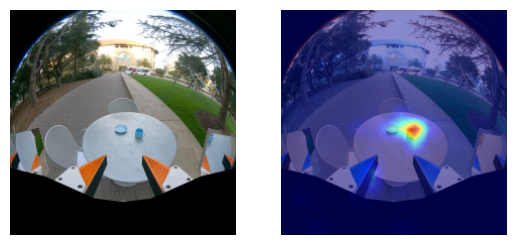

In [31]:
show_image_relevance(R, img, img)


In [25]:
policy.input_pertub

0.1

In [23]:
episode['action']

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00, -1.0828e-09,
          -6.0453e-11,  2.0326e-09,  1.0000e+00,  1.8717e-08,  8.1206e-02],
         [ 1.4288e-02,  6.1198e-03, -1.1971e-03,  1.0000e+00, -1.8908e-03,
           7.0725e-04,  1.8920e-03,  1.0000e+00, -1.6393e-03,  8.1068e-02],
         [ 1.4532e-02,  6.7760e-03, -1.8573e-03,  1.0000e+00, -2.0054e-03,
          -8.1158e-05,  2.0053e-03,  1.0000e+00, -9.9940e-04,  8.1101e-02],
         [ 1.3892e-02,  7.8841e-03, -1.7711e-03,  1.0000e+00, -1.7933e-03,
           2.0908e-04,  1.7935e-03,  1.0000e+00, -1.0085e-03,  8.1103e-02],
         [ 1.5310e-02,  9.1693e-03, -2.5515e-03,  1.0000e+00, -2.2636e-04,
          -1.0205e-04,  2.2612e-04,  1.0000e+00, -2.3410e-03,  8.1108e-02],
         [ 1.5946e-02,  1.0783e-02, -3.7125e-03,  1.0000e+00,  2.3406e-03,
          -1.6685e-03, -2.3478e-03,  9.9999e-01, -4.3680e-03,  8.1127e-02],
         [ 1.5464e-02,  1.1464e-02, -4.6611e-03,  9.9999e-01,  2.6286e-03,
          -3.8501e-